<a href="https://colab.research.google.com/github/smlacava/Themis/blob/main/CV_patch_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/smlacava/Themis/
!pip install facenet_pytorch
!unzip Themis/001.zip

Cloning into 'Themis'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
     |████████████████████████████████| 1.9 MB 29.3 MB/s 
Archive:  Themis/001.zip
  inflating: 001/001_01_01_010_00_crop_128.png  
  inflating: 001/001_01_01_010_01_crop_128.png  
  inflating: 001/001_01_01_010_02_crop_128.png  
  inflating: 001/001_01_01_010_03_crop_128.png  
  inflating: 001/001_01_01_010_04_crop_128.png  
  inflating: 001/001_01_01_010_05_crop_128.png  
  inflating: 001/001_01_01_010_06_crop_128.png  
  inflating: 001/001_01_01_010_07_crop_128.png  
  inflating: 001/001_01_01_010_08_crop_128.png  
  inflating: 001/001_01_01_010_09_crop_128.png  
  inflating: 001/001_01_01_010_10_crop_128.png  
  inflating: 001/001_01_01_010_11_crop_128.png  
  inflating: 001/001_01_01_010_12_crop_128.png  
  inflating: 001/001

In [2]:
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot  as plt
import numpy as np
import math
import os

In [3]:
mtcnn = MTCNN(image_size=160,
              margin=0,
              min_face_size=20,
              thresholds=[0.6, 0.7, 0.7], # MTCNN thresholds
              factor=0.709,
              post_process=True,
              device='cpu' # If you don't have GPU
        )

In [4]:
def visualize(image, landmarks_, angle_R_, angle_L_, pred_):
    fig , ax = plt.subplots(1, 1, figsize= (10,10))
    ax.set_title("Output Image")
    for landmarks, angle_R, angle_L, pred in zip(landmarks_, angle_R_, angle_L_, pred_):
        
        if pred == 'Frontal':
            color = 'white'
        elif pred == 'Right Profile':
            color = 'blue'
        else:
            color = 'red'
            
        point1 = [landmarks[0][0], landmarks[1][0]]
        point2 = [landmarks[0][1], landmarks[1][1]]

        point3 = [landmarks[2][0], landmarks[0][0]]
        point4 = [landmarks[2][1], landmarks[0][1]]

        point5 = [landmarks[2][0], landmarks[1][0]]
        point6 = [landmarks[2][1], landmarks[1][1]]
        for land in landmarks:
            ax.scatter(land[0], land[1])
        plt.plot(point1, point2, 'y', linewidth=3)
        plt.plot(point3, point4, 'y', linewidth=3)
        plt.plot(point5, point6, 'y', linewidth=3)
        plt.text(point1[0], point2[0], f"{pred} \n {math.floor(angle_L)}, {math.floor(angle_R)}", 
                size=20, ha="center", va="center", color=color)
    ax.imshow(image)

In [5]:
# Landmarks: [Left Eye], [Right eye], [nose], [left mouth], [right mouth]
def npAngle(a, b, c):
    ba = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b) 
    
    cosine_angle = np.dot(ba, bc)/(np.linalg.norm(ba)*np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

In [6]:
def load_image(img):
  """
  This function loads an image (if it has not already been loaded) and converts
  it in RGB format.

  Input:
    img: is a string of the name of the image (with its path) which has to be 
         downloaded or the image itself
  Output:
    img: is the image in RGB form
  """
  if isinstance(img, str):
    img = Image.open(img)
  if img.mode != "RGB": # Convert to RGB for MTCNN compatibility
      img = img.convert('RGB')
  return img

In [7]:
def detect_landmarks(img):
  img = load_image(img)
  bbox, prob, landmarks = mtcnn.detect(img, landmarks=True)
  return landmarks, prob, bbox

In [8]:
def face_pose(img):
  img = load_image(img)
  bbox_, prob_, landmarks_ = mtcnn.detect(img, landmarks=True) # The detection part producing bounding box, probability of the detected face, and the facial landmarks
    
  for bbox, landmarks, prob in zip(bbox_, landmarks_, prob_):
      if prob > 0.9: # To check if the detected face has probability more than 90%, to avoid 
        angR = npAngle(landmarks[0], landmarks[1], landmarks[2]) # Calculate the right eye angle
        angL = npAngle(landmarks[1], landmarks[0], landmarks[2])# Calculate the left eye angle
        if ((int(angR) in range(35, 57)) and (int(angL) in range(35, 58))):
            return "Frontal"
        else: 
            if angR < angL:
               return "Left"
            else:
               return "Right"

In [9]:
def predFacePose(img):

    img = load_image(img)
    
    bbox_, prob_, landmarks_ = mtcnn.detect(img, landmarks=True) # The detection part producing bounding box, probability of the detected face, and the facial landmarks
    angle_R_List = []
    angle_L_List = []
    predLabelList = []
    
    for bbox, landmarks, prob in zip(bbox_, landmarks_, prob_):
        if bbox is not None: # To check if we detect a face in the image
            if prob > 0.9: # To check if the detected face has probability more than 90%, to avoid 
                angR = npAngle(landmarks[0], landmarks[1], landmarks[2]) # Calculate the right eye angle
                angL = npAngle(landmarks[1], landmarks[0], landmarks[2])# Calculate the left eye angle
                angle_R_List.append(angR)
                angle_L_List.append(angL)
                if ((int(angR) in range(35, 57)) and (int(angL) in range(35, 58))):
                    predLabel='Frontal'
                    predLabelList.append(predLabel)
                else: 
                    if angR < angL:
                        predLabel='Left Profile'
                    else:
                        predLabel='Right Profile'
                    predLabelList.append(predLabel)
            else:
                print('The detected face is Less then the detection threshold')
        else:
            print('No face detected in the image')
    visualize(img, landmarks_, angle_R_List, angle_L_List, predLabelList)

In [10]:
files = os.listdir("001")
landmarks, prob, bbox = detect_landmarks("001/"+files[6])
print(landmarks)
print(bbox)

[[[64.26709 40.59815]
  [79.63266 37.56172]
  [90.83121 57.80453]
  [63.49112 84.03084]
  [79.19771 81.99407]]]
[[ 11.623686   -3.4975934  83.70862   110.521286 ]]


landmarks (x, y):

*   Left eye
*   Right eye
*   Nose
*   Left mouth edge
*   Right mouth edge



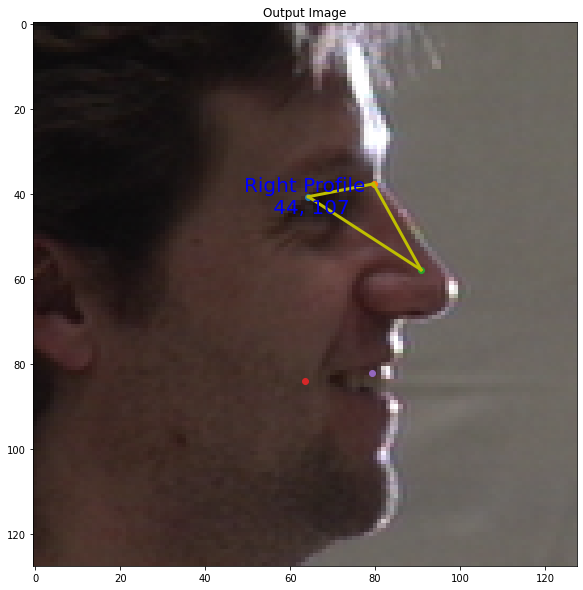

In [11]:
files = os.listdir("001")
predFacePose("001/"+files[6])

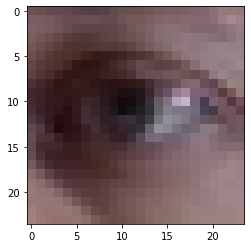

In [12]:
img = load_image("001/"+files[8])
pose = face_pose(img)
landmarks, prob, bbox = detect_landmarks(img)
np_img = np.array(img)
right_eye = []
left_eye = []
nose = []
left_mouth = []
right_mouth = []
if pose == "Frontal":
  right_eye = np_img[int(landmarks[0][0][1])-12:int(landmarks[0][0][1])+12, int(landmarks[0][0][0])-12:int(landmarks[0][0][0])+12, :]
  left_eye = np_img[int(landmarks[0][1][1])-12:int(landmarks[0][1][1])+12, int(landmarks[0][1][0])-12:int(landmarks[0][1][0])+12, :]
  nose = np_img[int(landmarks[0][2][1])-12:int(landmarks[0][2][1])+12, int(landmarks[0][2][0])-12:int(landmarks[0][2][0])+12, :]
  right_mouth = np_img[int(landmarks[0][3][1])-12:int(landmarks[0][3][1])+12, int(landmarks[0][3][0])-12:int(landmarks[0][3][0])+12, :]
  left_mouth = np_img[int(landmarks[0][4][1])-12:int(landmarks[0][4][1])+12, int(landmarks[0][4][0])-12:int(landmarks[0][4][0])+12, :]
  plt.imshow(nose)
elif pose == "Left":
  left_eye = np_img[int(landmarks[0][1][1])-12:int(landmarks[0][1][1])+12, int(landmarks[0][1][0])-12:int(landmarks[0][1][0])+12, :]
  nose = np_img[int(landmarks[0][2][1])-12:int(landmarks[0][2][1])+12, int(landmarks[0][2][0])-12:int(landmarks[0][2][0])+12, :]
  left_mouth = np_img[int(landmarks[0][4][1])-12:int(landmarks[0][4][1])+12, int(landmarks[0][4][0])-12:int(landmarks[0][4][0])+12, :]
  plt.imshow(left_eye)
else:
  right_eye = np_img[int(landmarks[0][0][1])-12:int(landmarks[0][0][1])+12, int(landmarks[0][0][0])-12:int(landmarks[0][0][0])+12, :]
  nose = np_img[int(landmarks[0][2][1])-12:int(landmarks[0][2][1])+12, int(landmarks[0][2][0])-12:int(landmarks[0][2][0])+12, :]
  right_mouth = np_img[int(landmarks[0][3][1])-12:int(landmarks[0][3][1])+12, int(landmarks[0][3][0])-12:int(landmarks[0][3][0])+12, :]
  plt.imshow(right_eye)

eye: 1/5 of the whole face => 25 px

righteye lefteye nose rightmouth leftmouth

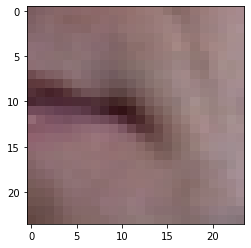

In [13]:
land = 4
plt.imshow(np_img[int(landmarks[0][land][1])-12:int(landmarks[0][land][1])+12, int(landmarks[0][land][0])-12:int(landmarks[0][land][0])+12, :])
plt.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import feature

np.set_printoptions(suppress=True)
class LocalBinaryPatterns():
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius

	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))

		# normalize the histogram
		hist = hist.astype("float")
		#eps is a small float added to avoid dividing by zero
		hist /= (hist.sum() + eps)

		# return the histogram of Local Binary Patterns
		return hist

In [20]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) # Y = 0.2989*R+0.5870*G+0.1140*B

In [26]:
from math import sqrt
import numpy as np 

def euclidean_distance(v1, v2):
  N = len(v1)
  aux = 0
  for i in range(N):
    aux += np.square(v1-v2)
  return sqrt(aux)

In [25]:
lbp = LocalBinaryPatterns(10, 5)
print(lbp.describe(rgb2gray(np_img[int(landmarks[0][land][1])-12:int(landmarks[0][land][1])+12, int(landmarks[0][land][0])-12:int(landmarks[0][land][0])+12, :])))

[0.13541667 0.10416667 0.09375    0.06944444 0.08159722 0.05208333
 0.04861111 0.02777778 0.02430556 0.03298611 0.02256944 0.30729167]
